In [1]:
import fastai.basics as fai
import fastai.vision as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import gc

import matplotlib.pyplot as plt

import torchvision as tv

import numpy as np
from functools import partial

In [2]:
def load_src(folder):
    return (fv.ImageList
              .from_folder(folder)
              .split_by_folder()
              .label_from_folder())    

def load_data(src, img_size, batch_size, fine_tuning = False):
    tfms = list(fv.get_transforms())
    if fine_tuning: tfms[0] = tfms[1]
    return (src.transform(tfms,size=img_size)
               .databunch(bs=batch_size))

In [3]:
path = Path('imagenette')

In [4]:
src = load_src(path)

In [5]:
src.c

20

In [6]:
def num_params(model):
    total=0
    for p in model.parameters():
        num=1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [7]:
model = nn.Sequential(
    nn.BatchNorm2d(3),
    nn.Conv2d(3,32,kernel_size=4,padding=1,stride=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,64,kernel_size=4,padding=1,stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64,128,kernel_size=4,padding=1,stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128,256,kernel_size=4,padding=1,stride=2),
    nn.AdaptiveAvgPool2d(1),
    fv.Flatten(),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256,src.c)
)

In [8]:
num_params(model)

696250

In [9]:
data = load_data(src, img_size=224, batch_size=64)

In [10]:
from xranger import XRanger

In [12]:
opt = partial(XRanger, betas=(0.93,0.99))

In [13]:
learn = fv.Learner(data,model,wd=0.0,
                   opt_func=opt,
                   true_wd=False,bn_wd=False,
                   metrics=[fv.accuracy])

In [ ]:
#learn.mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


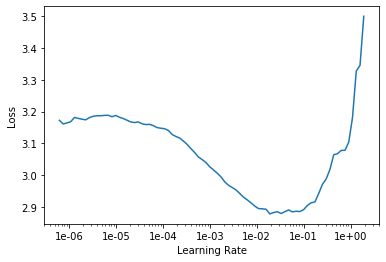

In [14]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.181818,1.953771,0.387000,00:41
1,1.789745,1.514914,0.498000,00:42
2,1.402880,1.227168,0.601000,00:41
3,1.134455,1.009099,0.675000,00:43


In [ ]:
img = torch.rand(64,3,224,224).cuda()

In [ ]:
%%timeit
torch.cuda.synchronize()
model(img)
torch.cuda.synchronize()

In [ ]:
r34 = fv.models.resnet34(pretrained=False).cuda()

In [ ]:
%%timeit
torch.cuda.synchronize()
r34(img)
torch.cuda.synchronize()

In [ ]:
2.73/37.4

In [ ]:
num_params(r34)